In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyFTS.common import Util

In [2]:
data_url = 'https://raw.githubusercontent.com/ZiggerZZ/taxitime/master/data/complete_data.csv'
df = pd.read_csv( data_url )
df['actual_landing_time'] = pd.to_datetime( df.actual_landing_time )
df['date'] = pd.to_datetime( df.date )

# Averaging per day
daily = df.loc[:, ['date', 't_minutes'] ].groupby( ['date'] ).mean()

# Averaging per hour
df['date_hour'] = df.actual_landing_time.apply( lambda x:x.strftime('%Y-%m-%d %H:00:00') )
hourly = df.loc[:, ['date_hour', 't_minutes', 'traffic_metric', 'minutes_of_day'] ].groupby( ['date_hour'] ).mean()


### Fuzzy Time Series

In [3]:
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.models.multivariate import variable
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, grid
from itertools import product

In [4]:
# Split train - validation sets
train_df = hourly.reset_index()[ : int(.8*hourly.shape[0]) ]
valid_df = hourly.reset_index()[ int(.8*hourly.shape[0]) : ]

In [18]:
# Predictors
sp = {'seasonality': DateTime.minute_of_day}
v_mins = variable.Variable("Minutes of Day", 
                           data_label= "minutes_of_day", 
                           partitioner= Grid.GridPartitioner, 
                           npart= 24,
                           data=train_df, 
                           partitioner_specific= sp)

# v_traffic = variable.Variable("Traffic", 
#                               data_label= "traffic_metric", 
#                               partitioner= Grid.GridPartitioner, 
#                               npart= 24, 
#                               data= train_df) 

# Response variable
levels = ['VL','L','M','H','VH']
sublevels = [str(k) for k in np.arange(0,5)]
names = []
for combination in product(*[levels, sublevels]):
    names.append(combination[0]+combination[1])

vavg = variable.Variable("Taxi Time", 
                         data_label= "t_minutes", 
                         alias= 't_mins',
                         partitioner= Grid.GridPartitioner, 
                         npart= 25, 
                         partitioner_specific= {'names': names},  
                         data= train_df) 

In [21]:
%%time


models = []
parameters = [ {},{}, {'order':2, 'knn': 2}]

for ct, method in enumerate([mvfts.MVFTS, 
                             wmvfts.WeightedMVFTS, 
                             cmvfts.ClusteredMVFTS]):
        if method != cmvfts.ClusteredMVFTS:
            model = method(explanatory_variables=[v_mins, vavg], target_variable=vavg, **parameters[ct])
        else:
            fs = grid.GridCluster(explanatory_variables=[v_mins, vavg], target_variable=vavg) #v_traffic,
            model = method(explanatory_variables=[v_mins, vavg], target_variable=vavg, partitioner=fs, **parameters[ct]) #v_traffic,
        model.name += str(ct)
        model.fit(train_df)
        models.append(model.shortname)
        forecasts = model.predict( valid_df.iloc[:100])
        Util.persist_obj(model, model.shortname)
        del(model)

CPU times: user 8.37 s, sys: 68.5 ms, total: 8.44 s
Wall time: 8.25 s


In [22]:
for model_name in models:
    model = Util.load_obj( model_name )
    rmse,_,_ = Measures.get_point_statistics( valid_df, model)
    print( f"Model: {model.name} \nOrder: {model.order} \nSize: {len(model)} \nRMSE: {rmse}",  '\n' )

Model: Multivariate FTS0 
Order: 1 
Size: 219 
RMSE: 4.93 

Model: Weighted Multivariate FTS1 
Order: 1 
Size: 219 
RMSE: 3.32 

Model: Clustered Multivariate FTS2 
Order: 2 
Size: 1299 
RMSE: 2.53 



### Test model

In [23]:
from datetime import datetime, timedelta

In [24]:
# TEST DATASET
test_url = 'https://raw.githubusercontent.com/ZiggerZZ/taxitime/master/data/test_complete_data.csv'
test_data = pd.read_csv( test_url )


test_data = test_data[['actual_landing_time', 't_minutes', 'minutes_of_day']] #, 'traffic_metric',]]
test_data['minutes_of_day'] = test_data.minutes_of_day.apply( lambda x: float(x) ) 
test_data['actual_landing_time'] = pd.to_datetime( test_data.actual_landing_time )
test_data['date_hour'] = test_data.actual_landing_time.apply( lambda x: datetime.strptime(x.strftime('%Y-%m-%d %H:00'), '%Y-%m-%d %H:00') )
test_data = test_data[['date_hour', 't_minutes', 'minutes_of_day']] #, 'traffic_metric']]
test_data.head(2)

,date_hour,t_minutes,minutes_of_day
0,2019-01-17 03:00:00,5.0,198.0
1,2019-01-17 03:00:00,7.0,216.0


In [11]:
# traffic_temp = test_data.groupby('date_hour').mean()
# traffic_temp.reset_index(inplace= True)

# hours_temp = pd.DataFrame( hours, columns=['date_hour'] )

# traffic_df = pd.merge(left= hours_temp, right= traffic_temp[['date_hour','traffic_metric']], left_on='date_hour',right_on='date_hour', how='left')
# traffic_df = traffic_df.fillna(method='ffill')
# traffic_df.head(2)

In [25]:
# Calculate range of hours = the number of points to predict 
# Create the sequence of hours to be predicted
steps = int((test_data.date_hour.max() - test_data.date_hour.min()).total_seconds()//3600)
earliest = test_data.date_hour.min()
hours = [earliest + timedelta(hours=i) for i in range(steps)]

# Get 2 earlierst hourly averages for the time-series to begin 
initial_points = test_data.groupby('date_hour').mean()[:2]
initial_points.head()

,t_minutes,minutes_of_day
date_hour,,
2019-01-17 03:00:00,6.166667,221.666667
2019-01-17 04:00:00,6.000000,248.000000


In [26]:
# Predict
# Generators
genMinutes = lambda x : x+60 if (x+1 <= 24*60) else 0
# genTraffic = lambda x : traffic_df.traffic_metric
# gen_dict = {'minutes_of_day': genMinutes} #, 'traffic_metric': genTraffic}

model = Util.load_obj( 'ClusteredMVFTS' )
forecast = model.predict( initial_points, 
                         steps_ahead= steps, 
                         generators= {'minutes_of_day': genMinutes})

# Wrap everything into a dataframe
pred_data = pd.DataFrame( zip(hours, forecast), columns= ['date_hour', 'prediction'] )
pred_data.head()

,date_hour,prediction
0,2019-01-17 03:00:00,7.371725
1,2019-01-17 04:00:00,8.627045
2,2019-01-17 05:00:00,8.387242
3,2019-01-17 06:00:00,8.104167
4,2019-01-17 07:00:00,8.284306


In [27]:
# INNER JOIN to the test dataset to get actuals with predictions together
test_data = pd.merge(test_data, pred_data, on='date_hour', how='inner')

In [28]:
# Calculate the Root Mean Square Error
rmse = lambda prediction, actual: (((prediction - actual) ** 2).mean())**(1/2)

rmse(test_data.t_minutes, test_data.prediction)

4.947279980953038

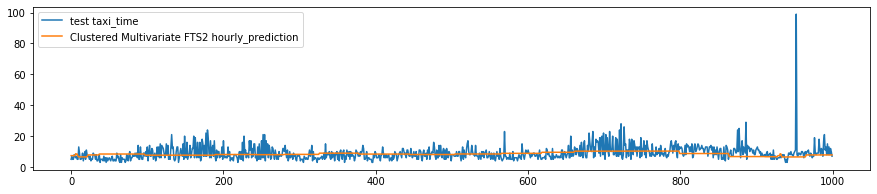

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
ax.plot(test_data.t_minutes[:1_000], label= 'test taxi_time')
ax.plot(test_data.prediction[:1_000], label= model.name+' hourly_prediction')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2)